<h1><center>INGV - Volcanic Eruption Prediction. Data Analysis.</center></h1>

<center><img src="https://images.ctfassets.net/81iqaqpfd8fy/3Wp4SEgzagcICaSqcIMOQM/5721655abf93a19521dad8a35d747f2d/Erupting_Volcano.jpg?h=620&w=1440"></center>

***GROUP 5***


#### SAI HARIKA PALURI
---
#### ABISHEK
---
#### DEVIKA UNNIKRISHNAN
---
#### SUMEET KUMAR
---
#### SATYA LAVANYA PERURI
---

#      Volcanic Eruption Prediction.

> In this competition, we will predict when a volcano's next eruption will occur. we are analyzing a large geophysical dataset collected by sensors deployed on active volcanoes.

> The dataset contains ten minutes of logs from ten different sensors arrayed around a volcano. 






In [ ]:
import os
import datetime
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy
import scipy.signal
import seaborn as sns
import plotly.express as px

from numpy import isnan
from sklearn.impute import KNNImputer

import matplotlib
import matplotlib.pyplot as plt
pd.options.display.max_columns = None    # disp all columns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# from lightgbm import LGBMRegressor
import lightgbm as lgb

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/predict-volcanic-eruptions'

Mounted at /content/gdrive


In [ ]:
%cd 'gdrive/My Drive/Colab Notebooks/predict-volcanic-eruptions'

/content/gdrive/My Drive/Colab Notebooks/predict-volcanic-eruptions


In [ ]:
train = pd.read_csv("train.csv")
sample_submission = pd.read_csv("sample_submission.csv")

**train.csv** Metadata for the train files.

* segment_id: ID code for the data segment. Matches the name of the associated data file.

* time_to_eruption: The target value, the time until the next eruption.

In [ ]:
train

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


**Time to Eruption is in centiseconds [ 1/100 second ]**

In [ ]:
fig = px.histogram(
    train, 
    x="time_to_eruption",
    width=800,
    height=500,
    nbins=100,
    title='Time to eruption distribution'
)

fig.show()

In [ ]:
fig = px.line(
    train, 
    y="time_to_eruption",
    width=800,
    height=500,
    title='Time to eruption for all volcanos'
)

fig.show()

## Distribution of Sensor Values across different segements

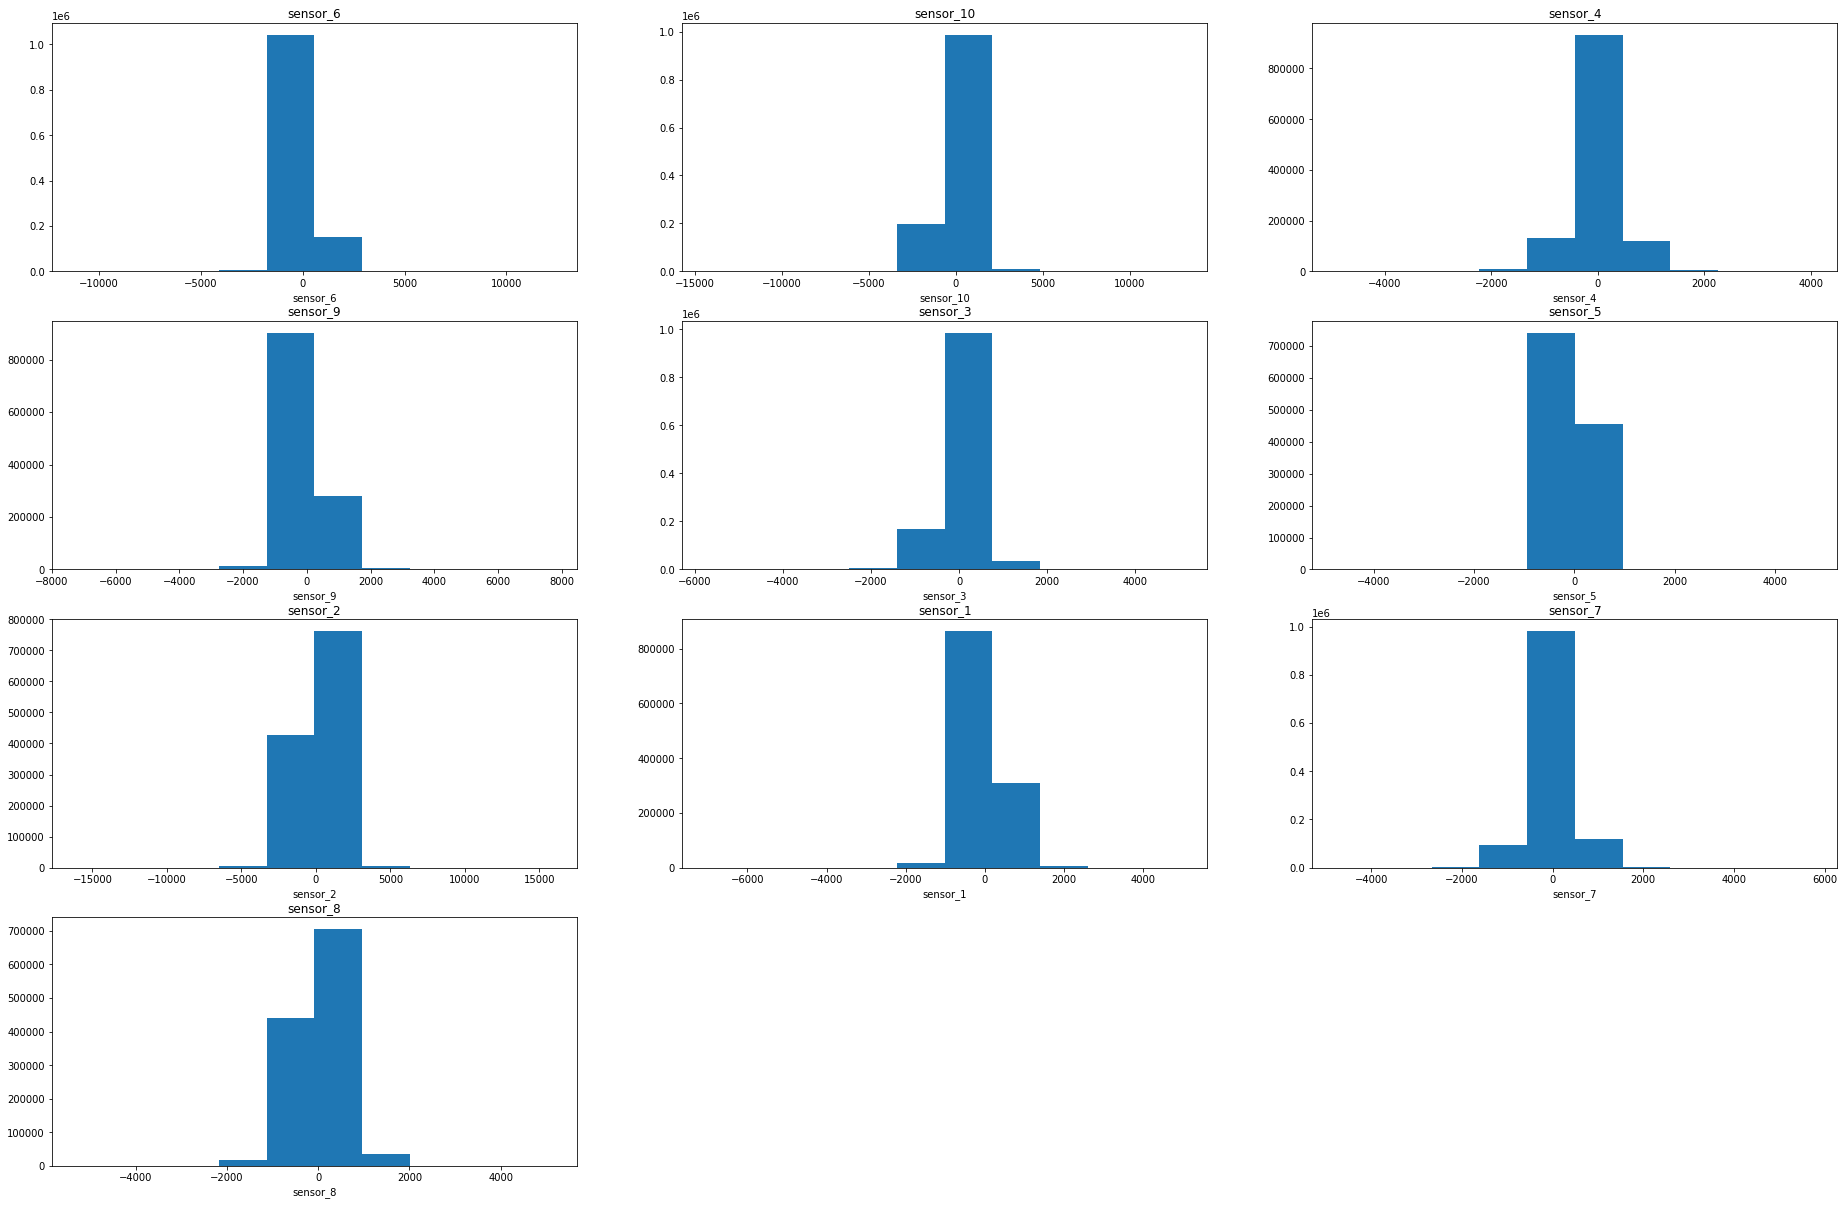

In [ ]:
train=pd.read_csv("train.csv")
train_final = pd.DataFrame(columns={'segment_id', 'time_to_eruption', 'sensor_1', 'sensor_2', 'sensor_3',
       'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9',
       'sensor_10'})
for i, row in train[0:20].iterrows():
  sensor_data = pd.read_csv("train/"+ str(row.segment_id) + ".csv")
  sensor_data=sensor_data.fillna(0)
  sensor_data['segment_id'] = row.segment_id
  train1 = train.merge(sensor_data, on='segment_id')
  # train_1_describe = pd.DataFrame(train1.describe()).reset_index()
  # train_1_describe['segment_id'] = row.segment_id
  train_final = pd.concat([train_final, train1], axis=0)
train_final = train_final.reset_index(drop=True)

sensor_values = train_final.drop(['time_to_eruption','segment_id'],axis=1)
graph = plt.figure(figsize=(32,32))
for value,feature in enumerate(sensor_values.columns):
  plt.subplot(6,3,value+1)
  plt.hist(sensor_values[feature])
  plt.xlabel(feature)
  plt.title(feature) 


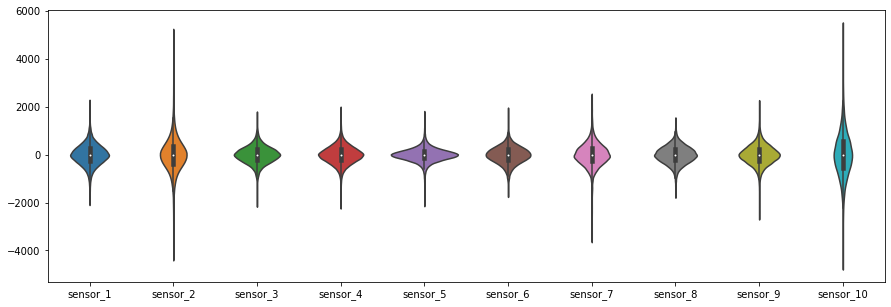

In [ ]:
df=pd.read_csv('train/1969647810.csv')
g = sns.violinplot(data=df)    #distribution across a single file
g.figure.set_size_inches(15,5)

# **STFT Implementation**

In [ ]:
# Convert 'time_to_eruption'to hours:minutes:seconds (Just for reference)
train['h:m:s'] = (train['time_to_eruption']
                  .apply(lambda x:datetime.timedelta(seconds = x/100)))
train

,segment_id,time_to_eruption,h:m:s
0,1136037770,12262005,1 days 10:03:40.050000
1,1969647810,32739612,3 days 18:56:36.120000
2,1895879680,14965999,1 days 17:34:19.990000
3,2068207140,26469720,3 days 01:31:37.200000
4,192955606,31072429,3 days 14:18:44.290000
...,...,...,...
4426,873340274,15695097,1 days 19:35:50.970000
4427,1297437712,35659379,4 days 03:03:13.790000
4428,694853998,31206935,3 days 14:41:09.350000
4429,1886987043,9598270,1 days 02:39:42.700000


In [ ]:
# plot utility function
def plot(ax, x, y, xlabel=None, ylabel=None, legend=None):
    ax.plot(x, y, label = legend)
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    if legend != None:
        ax.legend()
    ax.grid(True)

In [ ]:
# Select sample segment
sample_df = (train.sort_values('time_to_eruption')
             .reset_index()
             .rename(columns={'index': 'train_id'}))
sample_df = sample_df[sample_df.index % (len(train) // 5) == 5].reset_index(drop = True)
sample_ids = sample_df['segment_id'].values
sample_df

,train_id,segment_id,time_to_eruption,h:m:s
0,3942,775594946,52074,0 days 00:08:40.740000
1,636,2078096366,8991164,1 days 00:58:31.640000
2,4059,522506128,17972903,2 days 01:55:29.030000
3,3851,100610446,27292311,3 days 03:48:43.110000
4,2787,1003411703,36831703,4 days 06:18:37.030000


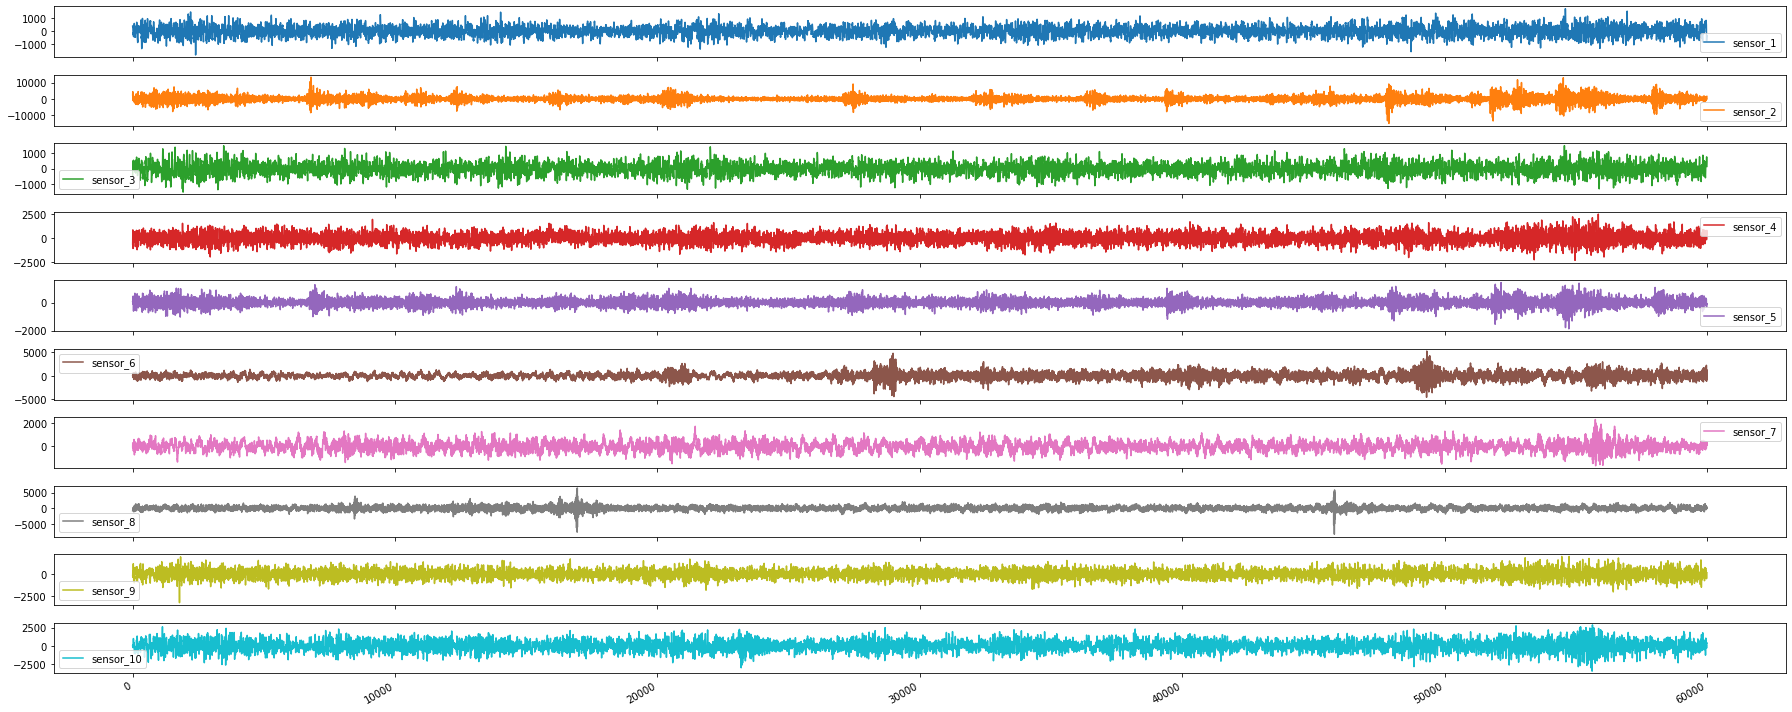

In [ ]:
def plot_sequence(segment_id):
    sequence = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/predict-volcanic-eruptions/train/"+segment_id+".csv", dtype="Int16")
    sequence.fillna(0).plot(subplots=True, figsize=(25, 10))
    plt.tight_layout()
    plt.show()

plot_sequence("2078096366")

# Time-Frequency Domain (STFT)

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning:

nperseg = 256 is greater than input length  = 5, using nperseg = 5



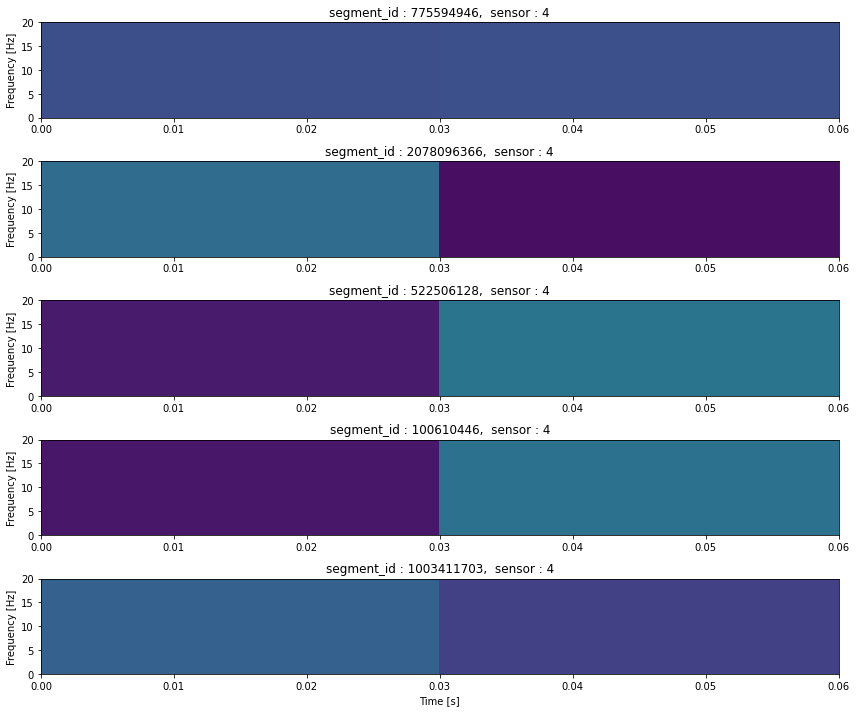

In [ ]:
fs = 100                # sampling frequency 
N = len(sample_df)     # data size
n = 256                 # FFT segment size
sensor = 4
fig, ax = plt.subplots(len(sample_ids), 1, figsize = (12, len(sample_ids)*2))
for i, segment_id in enumerate(sample_ids):
    segment_df = pd.read_csv(os.path.join('/content/gdrive/My Drive/Colab Notebooks/predict-volcanic-eruptions', f'train/{segment_id}.csv')).fillna(0)
    
    x = segment_df[f'sensor_{sensor}'][:N]
    f, t, Z = scipy.signal.stft(x, fs = fs, window = 'hann', nperseg = n)
    Z = np.abs(Z)

    ax[i].pcolormesh(t, f, Z, vmin = 0, vmax = Z.mean()*10)
    ax[i].set_ylim(0, 20)
    ax[i].set_ylabel('Frequency [Hz]'); plt.xlabel('Time [s]')
    ax[i].set_title(f'segment_id : {segment_id},  sensor : {sensor}')
fig.tight_layout()

In [ ]:
# STFT(Short Time Fourier Transform) Specifications
fs = 100                # sampling frequency 
N = len(segment_df)     # data size
n = 256                 # FFT segment size
max_f = 20              # ～20Hz

delta_f = fs / n        # 0.39Hz
delta_t = n / fs / 2    # 1.28s

## **Load Data & Cleanup NaN values**

In [ ]:
def cleanup_nan(X):
  imputer = KNNImputer()
  # fit on the dataset
  imputer.fit(X)
  # transform the dataset
  Xtrans = imputer.transform(X)
  X=Xtrans
  return X

**Preprocessing function to create new features from sensor values.**

In [ ]:
def make_features(tgt):
    tgt_df = train if tgt == 'train' else test
    feature_set = []
    for segment_id in tqdm(tgt_df['segment_id']):
        segment_df = pd.read_csv(os.path.join('/content/gdrive/My Drive/Colab Notebooks/predict-volcanic-eruptions',f'{tgt}/{segment_id}.csv'))
        segment = [segment_id]
        for sensor in segment_df.columns:
            x = segment_df[sensor][:N]
            if x.isna().sum() > 1000:     
                segment += ([np.NaN] * 10)
                continue
            f, t, Z = scipy.signal.stft(x.fillna(0), fs = fs, window = 'hann', nperseg = n)
            f = f[:round(max_f/delta_f)+1]
            Z = np.abs(Z[:round(max_f/delta_f)+1]).T    # ～max_f, row:time,col:freq
            th = Z.mean() * 1     
            Z_pow = Z.copy()
            Z_pow[Z < th] = 0
            Z_num = Z_pow.copy()
            Z_num[Z >= th] = 1

            Z_pow_sum = Z_pow.sum(axis = 0)
            Z_num_sum = Z_num.sum(axis = 0)

            A_pow = Z_pow_sum[round(10/delta_f):].sum()
            A_num = Z_num_sum[round(10/delta_f):].sum()
            BH_pow = Z_pow_sum[round(5/delta_f):round(8/delta_f)].sum()
            BH_num = Z_num_sum[round(5/delta_f):round(8/delta_f)].sum()
            BL_pow = Z_pow_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
            BL_num = Z_num_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
            C_pow = Z_pow_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
            C_num = Z_num_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
            D_pow = Z_pow_sum[round(2/delta_f):round(4/delta_f)].sum()
            D_num = Z_num_sum[round(2/delta_f):round(4/delta_f)].sum()
            segment += [A_pow, A_num, BH_pow, BH_num, BL_pow, BL_num, C_pow, C_num, D_pow, D_num]

        feature_set.append(segment)

    print('segment',segment)
    print('Feautures',feature_set)

    cols = ['segment_id']
    for i in range(10):
        for j in ['A_pow', 'A_num','BH_pow', 'BH_num','BL_pow', 'BL_num','C_pow', 'C_num','D_pow', 'D_num']:
            cols += [f's{i+1}_{j}']
    feature_df = pd.DataFrame(feature_set, columns = cols)
    feature_df['segment_id'] = feature_df['segment_id'].astype('int')
    return feature_df

In [ ]:
feature_df = make_features('train')


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
train_set = pd.merge(train, feature_df, on = 'segment_id')
train_set

,segment_id,time_to_eruption,h:m:s,s1_A_pow,s1_A_num,s1_BH_pow,s1_BH_num,s1_BL_pow,s1_BL_num,s1_C_pow,s1_C_num,s1_D_pow,s1_D_num,s2_A_pow,s2_A_num,s2_BH_pow,s2_BH_num,s2_BL_pow,s2_BL_num,s2_C_pow,s2_C_num,s2_D_pow,s2_D_num,s3_A_pow,s3_A_num,s3_BH_pow,s3_BH_num,s3_BL_pow,s3_BL_num,s3_C_pow,s3_C_num,s3_D_pow,s3_D_num,s4_A_pow,s4_A_num,s4_BH_pow,s4_BH_num,s4_BL_pow,s4_BL_num,s4_C_pow,s4_C_num,s4_D_pow,s4_D_num,s5_A_pow,s5_A_num,s5_BH_pow,s5_BH_num,s5_BL_pow,s5_BL_num,s5_C_pow,s5_C_num,s5_D_pow,s5_D_num,s6_A_pow,s6_A_num,s6_BH_pow,s6_BH_num,s6_BL_pow,s6_BL_num,s6_C_pow,s6_C_num,s6_D_pow,s6_D_num,s7_A_pow,s7_A_num,s7_BH_pow,s7_BH_num,s7_BL_pow,s7_BL_num,s7_C_pow,s7_C_num,s7_D_pow,s7_D_num,s8_A_pow,s8_A_num,s8_BH_pow,s8_BH_num,s8_BL_pow,s8_BL_num,s8_C_pow,s8_C_num,s8_D_pow,s8_D_num,s9_A_pow,s9_A_num,s9_BH_pow,s9_BH_num,s9_BL_pow,s9_BL_num,s9_C_pow,s9_C_num,s9_D_pow,s9_D_num,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,1136037770,12262005,1 days 10:03:40.050000,0.000000,0.0,5630.045792,271.0,46725.413729,841.0,37140.925547,452.0,72426.032531,1848.0,30798.673301,421.0,331692.549021,2631.0,45379.763380,468.0,22777.932701,225.0,206242.474535,1657.0,16604.279572,522.0,47417.802709,1311.0,40676.075383,769.0,33720.229669,437.0,80642.155584,1777.0,8226.754250,220.0,182647.140506,2530.0,35439.620873,582.0,24749.721001,356.0,103910.182217,1651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9850.349498,214.0,16342.737759,354.0,36798.893833,596.0,77124.060729,455.0,66246.422330,1193.0,64934.954957,1035.0,102382.207522,1654.0,9591.874414,200.0,54211.464091,436.0,54659.345814,936.0,55699.430380,871.0,171324.956616,2096.0,7302.118775,131.0,52497.482994,420.0,56240.599886,850.0,40650.624075,635.0,83811.917208,1731.0,48613.305829,738.0,27587.750677,383.0,136269.764337,1950.0,2120.558313,43.0,81355.190778,1444.0,84886.270473,807.0,60996.871589,442.0,157529.563619,1825.0
1,1969647810,32739612,3 days 18:56:36.120000,0.000000,0.0,8239.546856,261.0,96756.954746,905.0,66797.019816,459.0,155685.002604,2091.0,28311.404222,394.0,236875.196678,2186.0,73926.011019,686.0,62508.203810,410.0,236954.067044,1889.0,0.000000,0.0,21212.917778,680.0,71868.730548,890.0,53765.696758,456.0,138627.821898,2102.0,0.000000,0.0,69588.814054,1538.0,71812.521656,866.0,49043.632001,446.0,135523.407364,2033.0,15991.156821,519.0,97574.156730,2131.0,37620.555312,702.0,14755.819719,322.0,109499.370581,1891.0,11990.687424,499.0,3199.959299,134.0,28420.061216,690.0,49615.324005,457.0,18742.696073,654.0,10419.983969,251.0,331.805383,9.0,35505.323034,723.0,90047.526424,462.0,25576.660444,762.0,11512.524601,362.0,44068.650240,1417.0,26835.691567,633.0,37839.530270,446.0,32531.761508,1003.0,2921.678551,82.0,34504.990966,875.0,78329.871087,885.0,56109.209126,442.0,178402.868514,2131.0,0.000000,0.0,110965.707014,1173.0,201698.828245,894.0,106227.822676,446.0,408403.903691,2161.0
2,1895879680,14965999,1 days 17:34:19.990000,71.725726,5.0,8870.920230,441.0,49992.753708,895.0,33186.925457,451.0,79895.069257,1970.0,60841.404374,633.0,364248.554263,2555.0,48917.435679,417.0,17331.808264,163.0,264416.621659,1615.0,40.801135,3.0,18357.666521,916.0,39535.554602,864.0,30892.125860,452.0,69875.881502,1945.0,53035.528321,1636.0,79119.336288,1828.0,37269.130466,675.0,21254.507784,369.0,83760.330157,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.729067,13.0,1761.903231,69.0,34219.615180,732.0,78003.145316,463.0,22854.616940,723.0,0.000000,0.0,0.000000,0.0,17554.797533,656.0,53755.315654,463.0,15528.197577,759.0,2879.716593,120.0,12360.330994,560.0,13872.447596,475.0,45023.482933,458.0,17169.831636,694.0,7285.495271,214.0,40437.633546,1385.0,48696.184572,824.0,25843.988671,429.0,121920.149324,2090.0,37.333602,1.0,103640.522881,1860.0,103565.336246,878.0,49367.071923,433.0,194035.625316,2035.0
3,2068207140,26469720,3 days 01:31:37.200000,29.114857,2.0,6797.868928,388.0,54570.017925,893.0,31405.338852,460.0,80809.405321,2029.0,23147.282953,451.0,17

**Visualizing the features extracted**

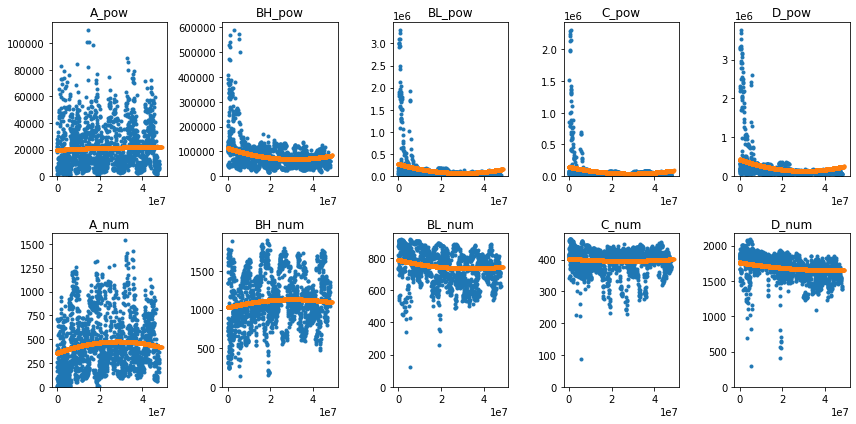

In [ ]:
fig, ax = plt.subplots(2, 5, figsize = (12, 6))
x = train_set['time_to_eruption']
for i,type in enumerate(['A_pow','A_num','BH_pow','BH_num','BL_pow','BL_num','C_pow','C_num','D_pow','D_num']):
    y = np.zeros(len(x))
    for j in range(10):
        y += train_set[f's{j+1}_{type}']
    y /= 10
    x1 = np.polyfit(x, y.fillna(y.mean()), 2)
    y1 = np.poly1d(x1)(x)
    ax[i%2, i//2].plot(x, y,'.')
    ax[i%2, i//2].plot(x, y1,'.')
    ax[i%2, i//2].set_ylim(0,)
    ax[i%2, i//2].set_title(type)
fig.tight_layout()

**Cleanup Nan with K-nn Imputer**

In [ ]:
# train_set = cleanup_nan(train_set)
df = train_set.drop(['segment_id', 'time_to_eruption','h:m:s'], axis=1)
y = train_set['time_to_eruption']

X_train, X_val, y_train, y_val = train_test_split(df, y,
                                                  random_state = 42,
                                                  test_size = 0.2,
                                                  shuffle = True)

features = X_train.columns.tolist()
cat_features = {}

In [ ]:
def do_lgb(X_train, y_train, X_val, y_val):
    params = {'objective': 'rmse',
              'metric': 'rmse',
              'boosting': 'gbdt',
              'max_depth':14,
              'num_boost_round':100,
              'min_data_in_leaf':7,         # = min_child_samples
              'num_leaves': 2**3 - 1,
              'learning_rate': 0.05,
              'feature_fraction': 0.7,      # = colsample_bytree
              'bagging_fraction': 0.5,      # = subsample
              'bagging_freq': 5,
              'lambda_l1':80,               # = reg_alpha
              'num_iterations': 10000,      # = n_estimators
              'seed': 42,
              'verbose': 1
             }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    evals_result = {}
    model = lgb.train(
        params,
        lgb_train,
        valid_sets = (lgb_train, lgb_eval), 
        feature_name = features,
        categorical_feature = cat_features,
        verbose_eval = 100,
        evals_result = evals_result,
        early_stopping_rounds = 200)

    return model

In [ ]:
lgb_model = do_lgb(X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is []



Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 6.15072e+06	valid_1's rmse: 6.73468e+06
[200]	training's rmse: 4.77291e+06	valid_1's rmse: 5.61994e+06
[300]	training's rmse: 3.98686e+06	valid_1's rmse: 5.11993e+06
[400]	training's rmse: 3.46854e+06	valid_1's rmse: 4.79049e+06
[500]	training's rmse: 3.09889e+06	valid_1's rmse: 4.56464e+06
[600]	training's rmse: 2.80212e+06	valid_1's rmse: 4.41448e+06
[700]	training's rmse: 2.56279e+06	valid_1's rmse: 4.3073e+06
[800]	training's rmse: 2.36306e+06	valid_1's rmse: 4.22334e+06
[900]	training's rmse: 2.18663e+06	valid_1's rmse: 4.16292e+06
[1000]	training's rmse: 2.03471e+06	valid_1's rmse: 4.10082e+06
[1100]	training's rmse: 1.89273e+06	valid_1's rmse: 4.05865e+06
[1200]	training's rmse: 1.77144e+06	valid_1's rmse: 4.02775e+06
[1300]	training's rmse: 1.66168e+06	valid_1's rmse: 3.97083e+06
[1400]	training's rmse: 1.56259e+06	valid_1's rmse: 3.95196e+06
[1500]	training's rmse: 1.47411e+06	valid_1's rmse:

In [ ]:
test = pd.read_csv(os.path.join('/content/gdrive/My Drive/Colab Notebooks/predict-volcanic-eruptions', 'sample_submission.csv'))

In [ ]:
feature_df = make_features('test')
test_set = pd.merge(test, feature_df, on = 'segment_id')
test_set

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,segment_id,time_to_eruption,s1_A_pow,s1_A_num,s1_BH_pow,s1_BH_num,s1_BL_pow,s1_BL_num,s1_C_pow,s1_C_num,s1_D_pow,s1_D_num,s2_A_pow,s2_A_num,s2_BH_pow,s2_BH_num,s2_BL_pow,s2_BL_num,s2_C_pow,s2_C_num,s2_D_pow,s2_D_num,s3_A_pow,s3_A_num,s3_BH_pow,s3_BH_num,s3_BL_pow,s3_BL_num,s3_C_pow,s3_C_num,s3_D_pow,s3_D_num,s4_A_pow,s4_A_num,s4_BH_pow,s4_BH_num,s4_BL_pow,s4_BL_num,s4_C_pow,s4_C_num,s4_D_pow,s4_D_num,s5_A_pow,s5_A_num,s5_BH_pow,s5_BH_num,s5_BL_pow,s5_BL_num,s5_C_pow,s5_C_num,s5_D_pow,s5_D_num,s6_A_pow,s6_A_num,s6_BH_pow,s6_BH_num,s6_BL_pow,s6_BL_num,s6_C_pow,s6_C_num,s6_D_pow,s6_D_num,s7_A_pow,s7_A_num,s7_BH_pow,s7_BH_num,s7_BL_pow,s7_BL_num,s7_C_pow,s7_C_num,s7_D_pow,s7_D_num,s8_A_pow,s8_A_num,s8_BH_pow,s8_BH_num,s8_BL_pow,s8_BL_num,s8_C_pow,s8_C_num,s8_D_pow,s8_D_num,s9_A_pow,s9_A_num,s9_BH_pow,s9_BH_num,s9_BL_pow,s9_BL_num,s9_C_pow,s9_C_num,s9_D_pow,s9_D_num,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,1000213997,0,17.597704,1.0,8867.910844,383.0,84216.480896,906.0,40063.801367,457.0,129329.572247,2089.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,12329.686177,531.0,83743.579877,908.0,36067.137375,452.0,128066.484698,2112.0,19522.721302,565.0,94577.144264,1951.0,81090.084587,876.0,29721.826931,418.0,128884.834872,1947.0,6228.606164,343.0,92750.760999,2567.0,24539.714448,749.0,6120.665609,252.0,80090.280239,2034.0,400009.957563,3721.0,28547.950037,492.0,13343.525219,244.0,38922.803397,396.0,3196.984853,70.0,38109.956014,1150.0,7152.710971,335.0,19224.228968,613.0,56029.993579,462.0,27700.819001,1100.0,83645.216306,1504.0,144065.622154,2095.0,26926.538302,546.0,29066.869996,381.0,89336.719607,1658.0,2344.267813,89.0,38405.792485,1098.0,85617.674926,890.0,29999.525930,431.0,159993.577910,2142.0,0.000000,12220.0,0.000000,3290.0,0.000000,940.0,0.000000,470.0,0.000000,2350.0
1,100023368,0,84.145374,4.0,3288.538144,144.0,65479.224244,895.0,38721.344199,457.0,98388.166044,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,8103.446900,363.0,54529.959940,890.0,34503.148680,451.0,92864.404037,2074.0,0.000000,0.0,68886.237507,1766.0,53345.784825,844.0,25864.208835,425.0,109242.327860,2017.0,8840.197574,454.0,66072.660922,2256.0,22301.080814,729.0,6440.216052,265.0,69723.938073,1933.0,4803.014790,127.0,2004.494271,55.0,26639.145520,529.0,87012.697593,458.0,10957.345086,281.0,41150.909812,1000.0,10581.007980,358.0,15757.552219,463.0,56271.150737,459.0,19085.847123,655.0,13295.427106,353.0,45306.877324,1223.0,13639.949086,373.0,52374.427127,445.0,13521.758923,420.0,18.259468,1.0,24206.073477,832.0,60432.819873,878.0,29015.140459,433.0,136848.722624,2146.0,0.000000,0.0,75226.889831,1254.0,98537.747734,865.0,51207.652288,437.0,235808.139324,2130.0
2,1000488999,0,25192.180094,1055.0,4050.298169,214.0,35901.306197,848.0,24588.850886,442.0,72748.339973,1949.0,55530.494518,949.0,229017.318766,2531.0,40649.329095,554.0,5974.050737,105.0,188498.680507,1855.0,0.000000,0.0,9682.905404,609.0,30396.672697,863.0,22501.453968,448.0,62481.368997,2062.0,143.539514,9.0,51506.966668,1855.0,35797.018409,833.0,19523.047731,427.0,75874.100422,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26088.699784,571.0,6834.790632,168.0,32698.860737,677.0,73751.085411,464.0,21398.393886,624.0,67.549012,4.0,4836.946384,306.0,10050.032671,487.0,39637.178535,461.0,25124.555051,1161.0,11981.925556,364.0,29037.429567,1052.0,7219.561731,276.0,46037.005157,453.0,6099.475194,254.0,73.290916,4.0,24803.750055,1165.0,38339.819152,853.0,22353.247578,437.0,100755.037771,2167.0,0.000000,12220.0,0.000000,3290.0,0.000000,940.0,0.000000,470.0,0.000000,2350.0
3,1001028887,0,587.607721,29.0,8463.698327,400.0,52453.575382,882.0,44181.661922,457.0,100428.209756,2083.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,14619.295874,712.0,43255.561050,878.0,40211.330176,462.0,85067.405824,2074.0,92.274897,4.0,82615.962381,2141.0,51242.915826,871.0,25838.309010,435.0,97689.120339,2040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
# Predict test data
preds = lgb_model.predict(test_set.drop(['segment_id', 'time_to_eruption'], axis=1))
test['time_to_eruption'] = preds
test[['segment_id','time_to_eruption']]

,segment_id,time_to_eruption
0,1000213997,3.115452e+07
1,100023368,3.744800e+07
2,1000488999,2.111320e+07
3,1001028887,2.469075e+07
4,1001857862,1.712790e+07
...,...,...
4515,996704281,2.858207e+07
4516,997630809,1.812567e+07
4517,998072137,2.693732e+07
4518,998136924,4.409231e+07


In [ ]:
test[['segment_id','time_to_eruption']].to_csv('submission.csv', index=False)